In [1]:
print('go')
import optim_esm_tools as oet
%run ../amoc_collapse_scripts/imports.py
from amoc_collapse_scripts import amoc_deep_dive, helper_scripts, amoc_deep_dive_group
from amoc_collapse_scripts.amoc_deep_dive import mask_to_full_mask

go
Hi there, have a great and productive day :)


In [2]:
base = "/data/volume_2/tipping_figures/2024_05_07_amoc/"
config = amoc_deep_dive_group.read_config(f'{base}/config.json')
oet.config.config.read_dict(config['config_update'])

figures_folder = os.path.join(base, 'paper', 'v2024.09.05_paper')
save_kw = dict(save_in=figures_folder, dpi=300, file_types=('png',))

smoother = partial(oet.analyze.tools.smooth_lowess, window=50)

smoother = lambda v, **kw: oet.analyze.tools.smooth_lowess(
    scipy.signal.savgol_filter(v,10,1),
    window=50, **kw)

In [3]:
def gausian_filter(y, n=100, mu=7.5):
    b = gaussian(n, mu)
    gauss = scipy.ndimage.convolve1d(y, b / b.sum())
    return gauss

smoother = gausian_filter

In [4]:
oet.utils.setup_plt()

In [5]:
folder_dict: ty.Dict[str, str] = amoc_deep_dive_group.read_config(config['read_from'])

In [6]:
for l in sorted(folder_dict):
    if folder_dict[l].get('folder_siconca') and not folder_dict[l].get('folder_siconc'):
        folder_dict[l]['folder_siconc']=folder_dict[l].get('folder_siconca')

In [7]:
label = 'MRI-ESM2-0 ssp126 r1i1p1f1'
label = 'UKESM1-0-LL ssp126 r4i1p1f2'

In [8]:
rename_dict = {'Greenland Sea': 'Nordic Seas', 
               'Norwegian Sea': 'Nordic Seas',
               'North Atlantic Ocean': 'Irminger Sea',
               'Baffin Bay': 'Labrador Sea',
               'Davis Strait': 'Labrador Sea'}

In [9]:
result_bucket = {}
for label in oet.utils.tqdm(sorted(folder_dict)):

    print(f'------------{label}--------------')
    ds_mlotst = oet.read_ds(
            folder_dict[label]["folder_mlotst"],
            add_history=True,
            max_time=None,
        ).load()
    amoc_deep_dive.set_time_int(ds_mlotst);

    result_bucket[label] = amoc_deep_dive.plot_mlotst_cells_full_ret(
            ds_mlotst,
            reference_depth=650,
            smooth_reference=True,
            min_cells=25,
            max_cells=200,
            show=False,
            label=label,
            field='mlotst_march',
            year_sel = slice(1965, 1995),
            mean_or_max='mean',
            _split_kw=dict(min_cells=5),
        rename_dict=rename_dict
            )


  0%|          | 0/26 [00:00<?, ?it/s]

------------ACCESS-CM2 ssp126 r1i1p1f1--------------
Nordic Seas 50
Nordic Seas 140
Irminger Sea 243
------------ACCESS-CM2 ssp585 r1i1p1f1--------------
Nordic Seas 50
Nordic Seas 140
Irminger Sea 243
------------ACCESS-ESM1-5 ssp126 r1i1p1f1--------------
Nordic Seas 28
Nordic Seas 138
Irminger Sea 242
------------ACCESS-ESM1-5 ssp585 r1i1p1f1--------------
Nordic Seas 28
Nordic Seas 138
Irminger Sea 242
------------CESM2-WACCM ssp126 r1i1p1f1--------------
Irminger Sea 161
Labrador Sea 61
Labrador Sea 89
------------CESM2-WACCM ssp585 r1i1p1f1--------------
Irminger Sea 161
Labrador Sea 61
Labrador Sea 89
------------CanESM5 ssp126 r1i1p1f1--------------
Nordic Seas 77
Nordic Seas 131
Irminger Sea 5
------------CanESM5 ssp585 r1i1p1f1--------------
Nordic Seas 77
Nordic Seas 131
Irminger Sea 5
------------GISS-E2-1-G ssp126 r1i1p1f2--------------
Nordic Seas 34
Labrador Sea 7
Nordic Seas 71
Irminger Sea 427
Labrador Sea 88
Labrador Sea 134
------------GISS-E2-1-G ssp126 r3i1p1f2----

In [10]:
_cc = oet.utils.get_plt_colors()
del _cc[1:4]
global_color_dict = {v:k for k,v in zip(_cc, ['Nordic Seas', 
'Irminger Sea',
'Labrador Sea',])}
global_color_dict

{'Nordic Seas': '#e41a1c',
 'Irminger Sea': '#ff7f00',
 'Labrador Sea': '#a65628'}

In [11]:
def plot_result_buckets(res_0, res_1=None, ax=None, ax2=None, projection='LambertAzimuthalEqualArea', **kw):

    plt.figure(figsize=(10,10))
    a = 2,1
    _cc = oet.utils.get_plt_colors()
    del _cc[1:4]
    _cc.append(_cc.pop(2))
    xmin, xmax = -70, 5
    ymin, ymax = 33, 81
    if ax is None:
        ax = plt.gcf().add_subplot(
            *a,1,projection=oet.plotting.plot.get_cartopy_projection(projection=projection, 
                                                                    central_longitude=(xmin+xmax)/2,
                                                                     central_latitude=(ymin+ymax)/2)
        )
        ax.set_extent([xmin,xmax,ymin,ymax])
        ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '110m', edgecolor='k', facecolor='gainsboro', zorder=2))

        ax.add_feature(cfeature.COASTLINE)
        gl = ax.gridlines(draw_labels=True, zorder=1)
        gl.top_labels=False
        gl.right_labels=False

    single_sets = []
    for idx in np.unique(res_0.region_map.values):
        if idx == 0:
            continue
        single_sets.append(res_0.region_map == idx)
    single_sets = sorted(
            single_sets,
            key=lambda x: partial(amoc_deep_dive.median_lat_lon, ds=res_0.full_ds)(x.values)[1],
        )

    res_0.da_global.plot(
        ax=ax, 
        transform=oet.plotting.plot.get_cartopy_transform(),
        **{
            **dict(vmin=0,
                   vmax=res_0.da_basis.max(),
                   cbar_kwargs=dict(label=f'Mixed layer depth in March [m] {res_0.year_str}')
                  ),
            **kw
        }
    )
    for s,c in zip(single_sets, res_0.labels):
        plt.sca(ax)
        amoc_deep_dive.overlay_contour((s>0).astype(np.float32), 
                                       levels=[0.5,1.5], linewidths=2, 
                                       colors=global_color_dict[res_0.region_names[c]],
                                       zorder=2,
                                      transform=oet.plotting.plot.get_cartopy_transform())

    for label, coord in zip(res_0.labels, res_0.median_coords):
        x,y=coord[::-1]
        
        ax.text(x,y, res_0.region_names[label][:1],
                c=global_color_dict[res_0.region_names[label]],
                ha="center", va="center", 
                fontsize='large',
                weight='bold',
                zorder=2,
                transform=oet.plotting.plot.get_cartopy_transform()
               )
    ax2 = ax2 or plt.gcf().add_subplot(*a,2,)
    
    for label, y in zip(res_0.labels, res_0.averaged_values):
        _id = res_0.label.split()[1] if not 'ssp245' in res_0.label else res_0.label.split()[2]
        ax2.plot(res_0.timestamps, smoother(y),
                 c=global_color_dict[res_0.region_names[label]], label=f'{res_0.region_names[label]} - {_id}')
    if res_1 is not None:
        for label, y in zip(res_1.labels, res_1.averaged_values):
            _id = res_1.label.split()[1] if not 'ssp245' in res_1.label else res_1.label.split()[2]
            ax2.plot(res_1.timestamps, smoother(y), 
                     c=global_color_dict[res_0.region_names[label]], ls= '--', label=f'{_id}')
    ax2.set_ylabel(f'Mixed layer depth in March [m] ')
    ax2.legend(loc='best', ncol= 1 + (res_1 is not None))
   
    plt.suptitle(bake_title(res_0, res_1), y=0.93)

In [12]:
def bake_title(res_0, res_1):
    title = res_0.label.split()
    if res_1 is not None:
        if res_1.label.split()[2] != title[2]:
            title[2] = ', '.join(sorted([title[2] , res_1.label.split()[2]]))
        else:
            title[1] = ', '.join(sorted([title[1] , res_1.label.split()[1]]))
    return ' '.join(title)

In [13]:
group_labels = [

                ['ACCESS-CM2 ssp126 r1i1p1f1',  'ACCESS-CM2 ssp585 r1i1p1f1',],
                ['CESM2-WACCM ssp126 r1i1p1f1', 'CESM2-WACCM ssp585 r1i1p1f1'],
                ['CanESM5 ssp126 r1i1p1f1', 'CanESM5 ssp585 r1i1p1f1'],
                ['GISS-E2-1-G ssp126 r1i1p1f2', 'GISS-E2-1-G ssp585 r1i1p1f2',],
                ['GISS-E2-1-G ssp245 r1i1p1f2', 'GISS-E2-1-G ssp245 r3i1p1f2',],
                ['IPSL-CM6A-LR ssp126 r1i1p1f1', 'IPSL-CM6A-LR ssp585 r1i1p1f1',],
                ['MRI-ESM2-0 ssp126 r1i1p1f1', 'MRI-ESM2-0 ssp585 r1i1p1f1',],
                ['UKESM1-0-LL ssp126 r4i1p1f2','UKESM1-0-LL ssp585 r4i1p1f2'],
                ['NorESM2-MM ssp126 r1i1p1f1', 'NorESM2-MM ssp585 r1i1p1f1',],
                ['ACCESS-ESM1-5 ssp126 r1i1p1f1', 'ACCESS-ESM1-5 ssp585 r1i1p1f1',], 
                ['GISS-E2-1-G ssp126 r1i1p1f2','GISS-E2-1-G ssp585 r1i1p1f2',],
]
group_labels = [g[::-1] for g in group_labels]

In [14]:
list(enumerate(group_labels))

[(0, ['ACCESS-CM2 ssp585 r1i1p1f1', 'ACCESS-CM2 ssp126 r1i1p1f1']),
 (1, ['CESM2-WACCM ssp585 r1i1p1f1', 'CESM2-WACCM ssp126 r1i1p1f1']),
 (2, ['CanESM5 ssp585 r1i1p1f1', 'CanESM5 ssp126 r1i1p1f1']),
 (3, ['GISS-E2-1-G ssp585 r1i1p1f2', 'GISS-E2-1-G ssp126 r1i1p1f2']),
 (4, ['GISS-E2-1-G ssp245 r3i1p1f2', 'GISS-E2-1-G ssp245 r1i1p1f2']),
 (5, ['IPSL-CM6A-LR ssp585 r1i1p1f1', 'IPSL-CM6A-LR ssp126 r1i1p1f1']),
 (6, ['MRI-ESM2-0 ssp585 r1i1p1f1', 'MRI-ESM2-0 ssp126 r1i1p1f1']),
 (7, ['UKESM1-0-LL ssp585 r4i1p1f2', 'UKESM1-0-LL ssp126 r4i1p1f2']),
 (8, ['NorESM2-MM ssp585 r1i1p1f1', 'NorESM2-MM ssp126 r1i1p1f1']),
 (9, ['ACCESS-ESM1-5 ssp585 r1i1p1f1', 'ACCESS-ESM1-5 ssp126 r1i1p1f1']),
 (10, ['GISS-E2-1-G ssp585 r1i1p1f2', 'GISS-E2-1-G ssp126 r1i1p1f2'])]

In [15]:
def add_cart_ax(a,idx):
    xmin, xmax = -70, 5
    ymin, ymax = 33, 81
    projection='LambertAzimuthalEqualArea'
    ax = plt.gcf().add_subplot(
        *a,idx,projection=oet.plotting.plot.get_cartopy_projection(projection=projection, 
                                                            central_longitude=(xmin+xmax)/2,
                                                             central_latitude=(ymin+ymax)/2)
)
    ax.set_extent([xmin,xmax,ymin,ymax])
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '110m', edgecolor='k', facecolor='gainsboro', zorder=2))
    ax.add_feature(cfeature.COASTLINE)
    gl = ax.gridlines(draw_labels=True, zorder=1)
    gl.top_labels=False
    gl.right_labels=False
    
    return ax

In [16]:
def add_cart_ax(a,idx):
    xmin, xmax = -70, 5
    ymin, ymax = 33, 81
    projection='LambertAzimuthalEqualArea'
    ax = plt.gcf().add_subplot(
        *a,idx,projection=oet.plotting.plot.get_cartopy_projection(projection=projection, 
                                                            central_longitude=(xmin+xmax)/2,
                                                             central_latitude=(ymin+ymax)/2)
)
    ax.set_extent([xmin,xmax,ymin,ymax])
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '110m', edgecolor='k', facecolor='gainsboro', zorder=2))
    ax.add_feature(cfeature.COASTLINE)
    gl = ax.gridlines(draw_labels=True, zorder=1)
    gl.top_labels=False
    gl.right_labels=False
    
    return ax

In [17]:
fig_name = 'figure_2'

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

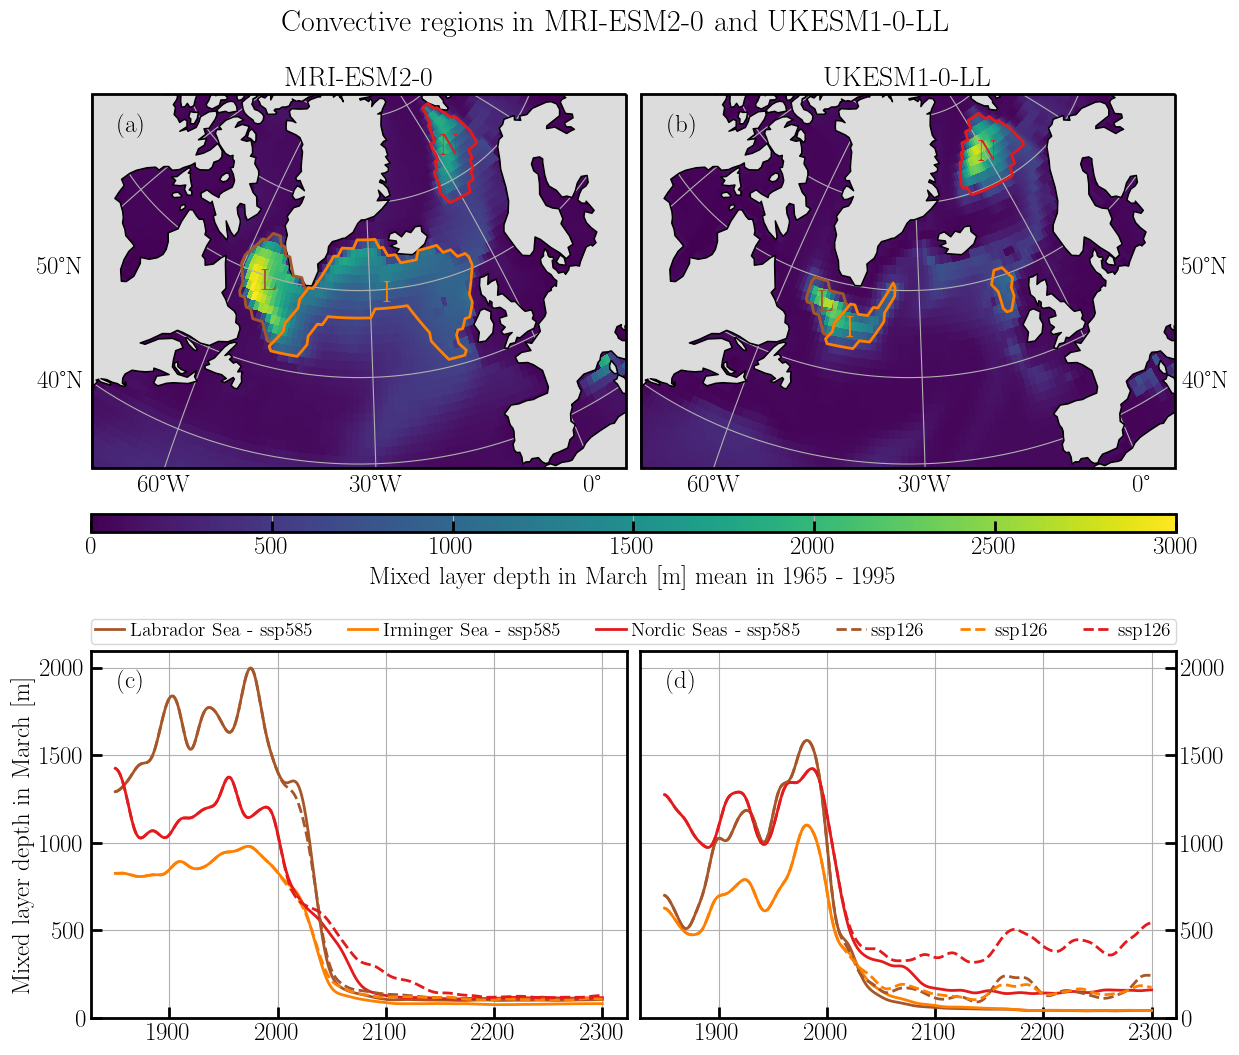

In [18]:
a=3,2

xmin, xmax = -70, 5
ymin, ymax = 33, 81
projection='LambertAzimuthalEqualArea'
map_kw = dict(projection=oet.plotting.plot.get_cartopy_projection(projection=projection, 
                                                                  central_longitude=(xmin+xmax)/2,
                                                                  central_latitude=(ymin+ymax)/2))

fig, axes = plt.subplot_mosaic('ab\n..\nll\n..\ncd',
                               figsize=(14,12),
                               height_ratios=[1.02, 0.1, 0.05, 0.3,1],
                               gridspec_kw=dict(hspace=0.025, wspace=0.025),
                               per_subplot_kw=dict(a=map_kw, b=map_kw))

cmap = mpl.cm.viridis
kw = dict(vmin=0, vmax=3000, add_colorbar=False, cmap=cmap,cbar_kwargs=None)
norm = mpl.colors.Normalize(vmin=kw['vmin'], vmax=kw['vmax'])

for k in 'ab':
    ax = axes[k]
    ax.set_extent([xmin,xmax,ymin,ymax])
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '110m', 
                                                edgecolor='k', facecolor='gainsboro', zorder=2))
    ax.add_feature(cfeature.COASTLINE)
    gl = ax.gridlines(draw_labels=True, zorder=1)
    gl.top_labels=False
    gl.right_labels=False


cb1 = mpl.colorbar.ColorbarBase(axes['l'], 
                                cmap=cmap,
                                norm=norm,
                                orientation='horizontal',)

axes_left=[axes['a'], axes['c']]
axes_right=[axes['b'], axes['d']]

ax = axes_right[0]
ax._gridliners[0].right_labels = True
ax._gridliners[0].left_labels = False
ax = axes_right[1]
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")

g = group_labels[6]
res_0 = result_bucket[g[0]]
res_1 = result_bucket[g[1]]

ax, ax2 = axes_left
plt.sca(ax)
plot_result_buckets(res_0,res_1, ax=ax, ax2=ax2, **kw )

title = bake_title(res_0, res_1)
axes_left[0].set_title(title.split()[0])

g = group_labels[7]
res_0 = result_bucket[g[0]]
res_1 = result_bucket[g[1]]
## Change the position of the label
res_0 = amoc_deep_dive.MlotstRegion(**res_0.__dict__.copy())
cc = list(res_0.median_coords.copy())
cc[1]  = (55, -44)
res_0.median_coords = tuple(cc)

ax, ax2 = axes_right
plt.sca(ax)
plot_result_buckets(res_0,res_1, ax=ax, ax2=ax2, **kw)
title = bake_title(res_0, res_1)
axes_right[0].set_title(title.split()[0])


ax_l=axes_left[1]
ax_r=axes_right[1]
ax_r.get_legend().set_visible(False) 
ax_r.set_ylabel('')

ax_l.legend(**oet.utils.legend_kw(
    bbox_to_anchor=(0, 1.02, 2*1.0125, 0.32),
    ncol=6, 
    handlelength=1.5,
    labelspacing=0.3, 
    handletextpad=0.3,
    columnspacing=0.8,
    borderpad=0.2,
))
y_lims = np.array([ax.get_ylim() for ax in [ax_l, ax_r]])
x_lims = np.array([ax.get_xlim() for ax in [ax_l, ax_r]])

y_lim = np.min(y_lims), np.max(y_lims)
x_lim = np.min(x_lims), np.max(x_lims)

for ax in ax_l, ax_r:
    ax.set_ylim(0, y_lim[1])
    ax.set_xlim(*x_lim)
    
for k in 'abcd':
    axes[k].text(0.05,0.95,f'({k})',va='top', transform=axes[k].transAxes)
plt.suptitle(f'Convective regions in {group_labels[6][0].split()[0]} and {group_labels[7][0].split()[0]}', y=0.95)
cb1.set_label(f'Mixed layer depth in March [m] {res_0.year_str}')
oet.utils.save_fig(name=f'{group_labels[6][0].split()[0]} and {group_labels[7][0].split()[0]}',
                   sub_dir=fig_name, 
                   **save_kw)
plt.show()

In [19]:
for i, g in enumerate(group_labels):
    if i == 4:
        continue


In [20]:
def new_res_bucket(res_0, res_1=None):

    xmin, xmax = -70, 5
    ymin, ymax = 33, 81
    projection='LambertAzimuthalEqualArea'
    map_kw = dict(projection=oet.plotting.plot.get_cartopy_projection(projection=projection, 
                                                                      central_longitude=(xmin+xmax)/2,
                                                                      central_latitude=(ymin+ymax)/2))

    fig, axes = plt.subplot_mosaic('a\nb',
                                   figsize=(10,12),
                                   height_ratios=[2,1],
                                   gridspec_kw=dict(hspace=0.1, wspace=0.025),
                                   per_subplot_kw=dict(a=map_kw))

    cmap = mpl.cm.viridis
    kw = dict(add_colorbar=True, cmap=cmap,cbar_kwargs=dict(orientation='horizontal',
                                                            aspect=40,
    #                                                         shrink=0.5,
                                                            pad=0.07,
                                                            label=f'Mixed layer depth in March [m] {res_0.year_str}'))
    for k in 'a':
        ax = axes[k]
        off=10
        ax.set_extent([xmin-off,xmax+off,ymin,ymax])
        ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '110m', 
                                                    edgecolor='k', facecolor='gainsboro', zorder=2))
        ax.add_feature(cfeature.COASTLINE)
        gl = ax.gridlines(draw_labels=True, zorder=1)
        gl.top_labels=False
        gl.right_labels=False
    plot_result_buckets(res_0 = res_0, res_1 = res_1, ax=axes['a'], ax2=axes['b'], **kw)
    axes['b'].legend(**oet.utils.legend_kw(
        ncol=3, 
        handlelength=1.5,
        labelspacing=0.3, 
        handletextpad=0.3,
        columnspacing=0.8,
        borderpad=0.2,))
    axes['a'].set_title(f'Convective regions in {res_0.label.split()[0]}')
    plt.suptitle('')

/tmp/ipykernel_390643/1391563033.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplot_mosaic('a\nb',


<Figure size 1000x1000 with 0 Axes>

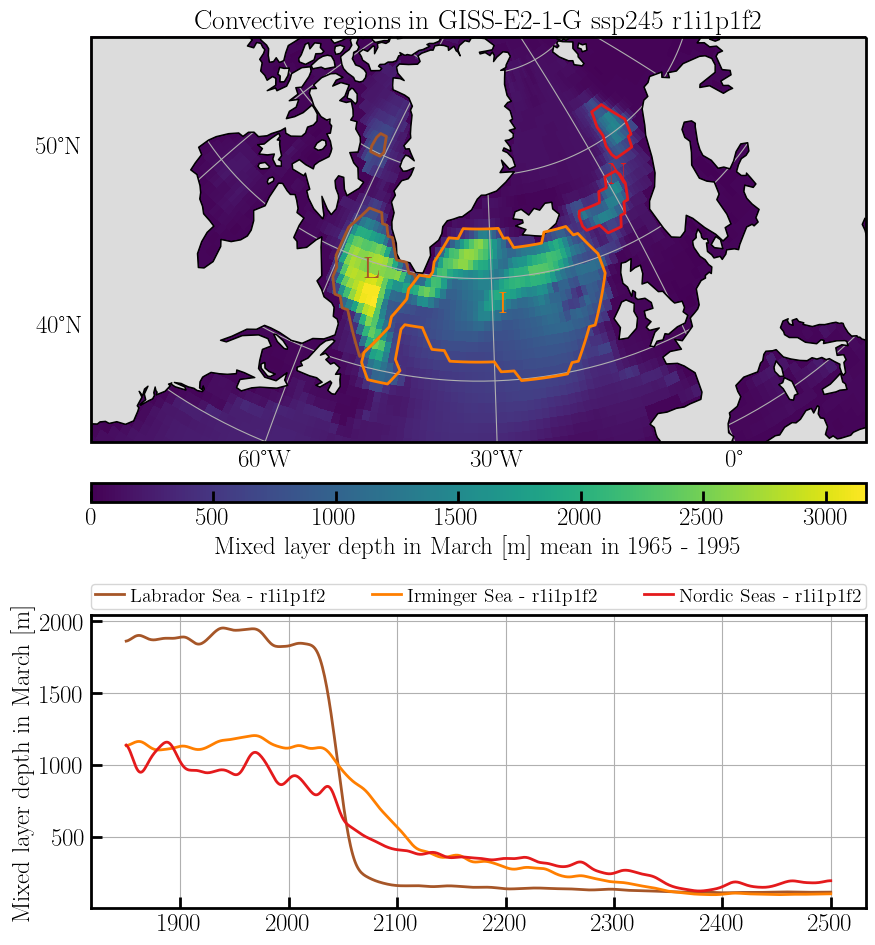

<Figure size 1000x1000 with 0 Axes>

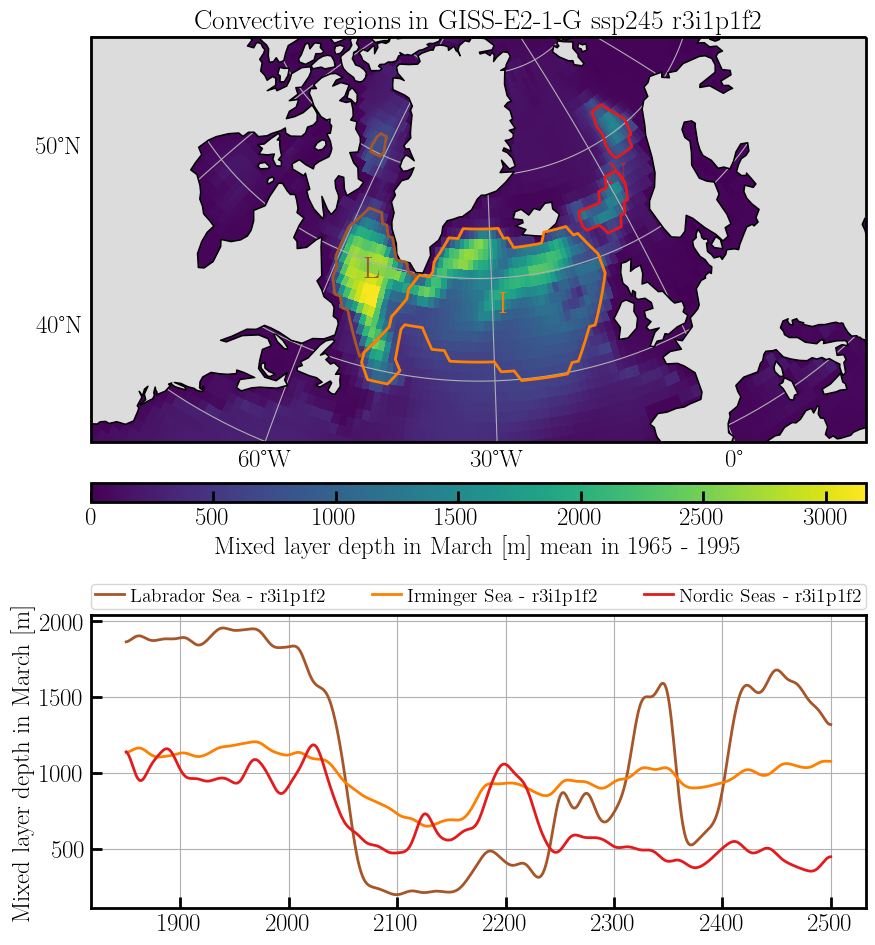

<Figure size 1000x1000 with 0 Axes>

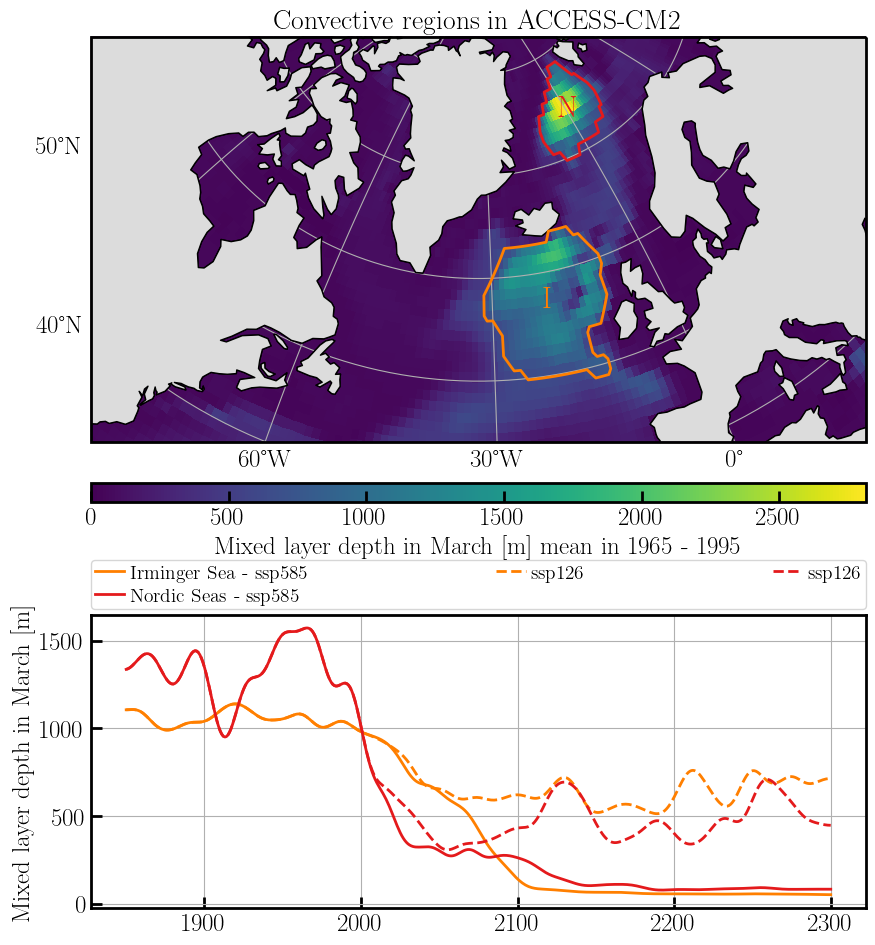

<Figure size 1000x1000 with 0 Axes>

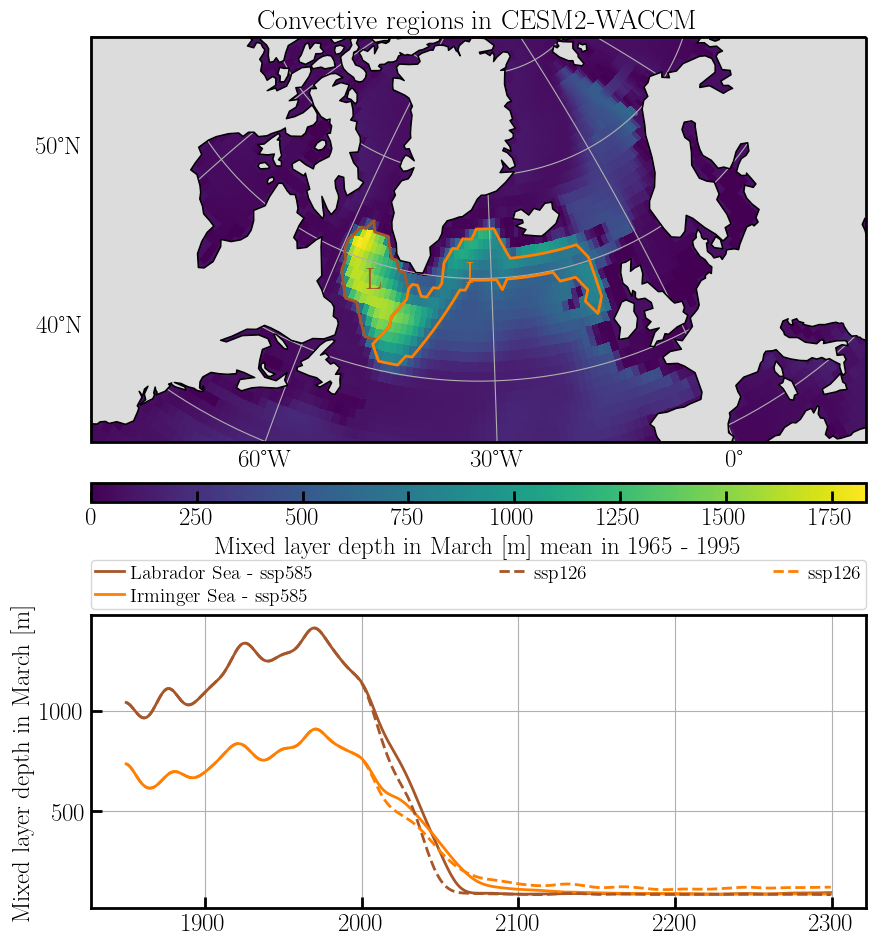

<Figure size 1000x1000 with 0 Axes>

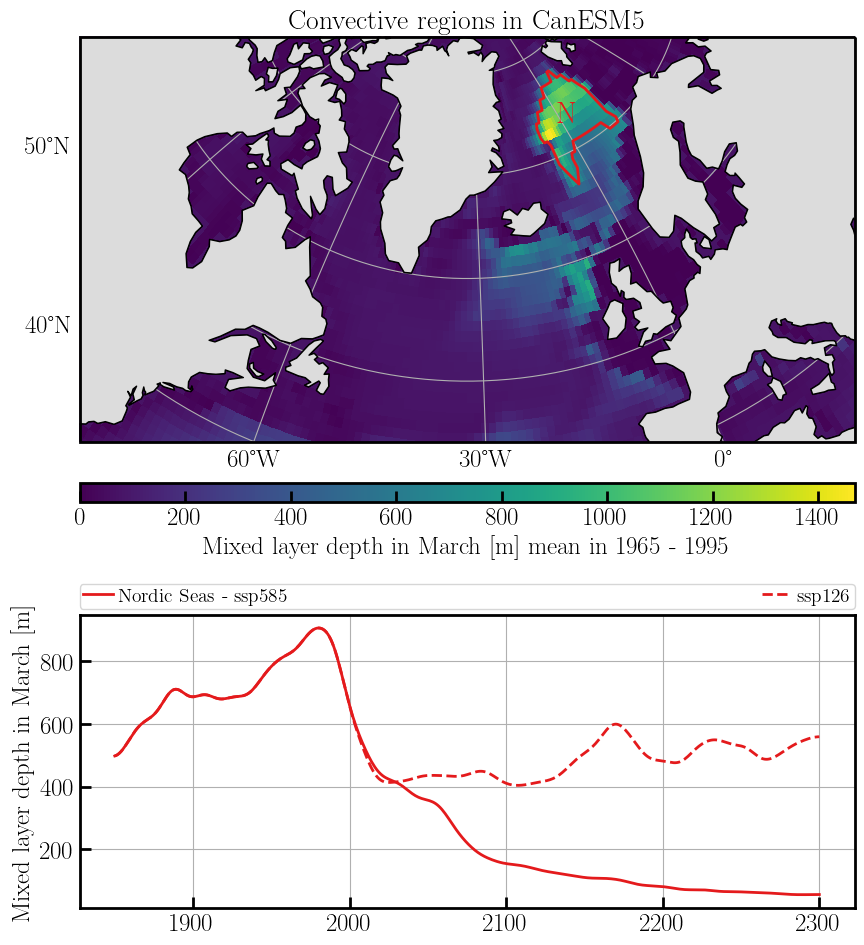

<Figure size 1000x1000 with 0 Axes>

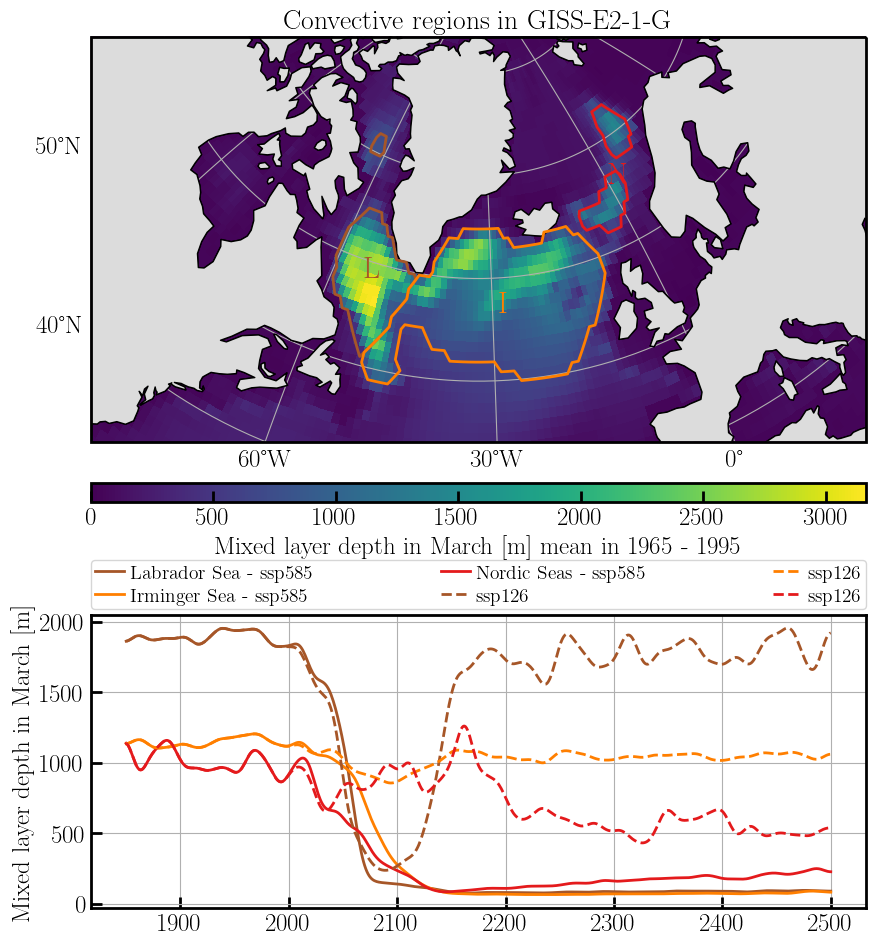

<Figure size 1000x1000 with 0 Axes>

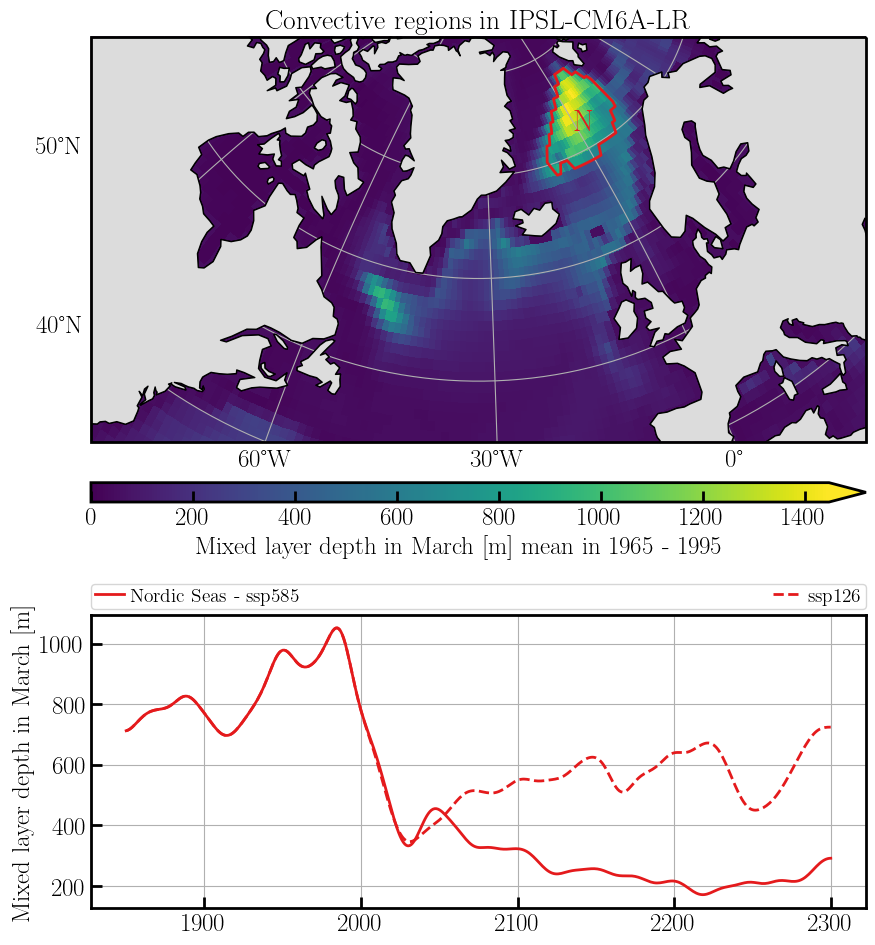

<Figure size 1000x1000 with 0 Axes>

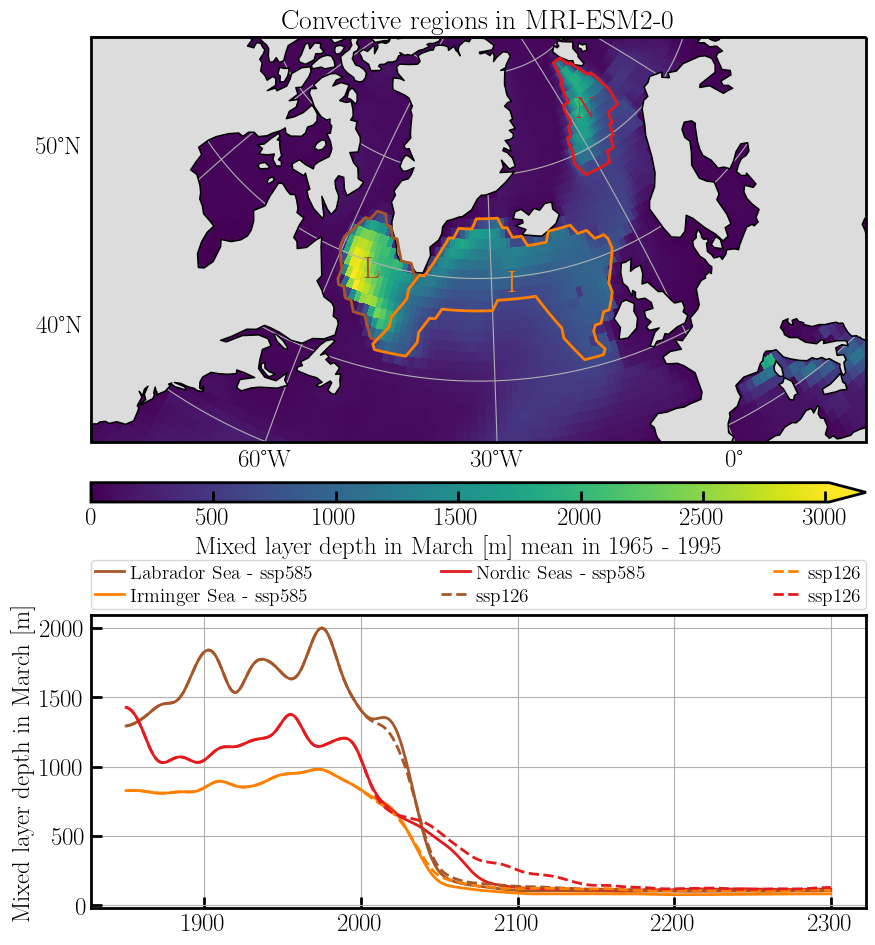

<Figure size 1000x1000 with 0 Axes>

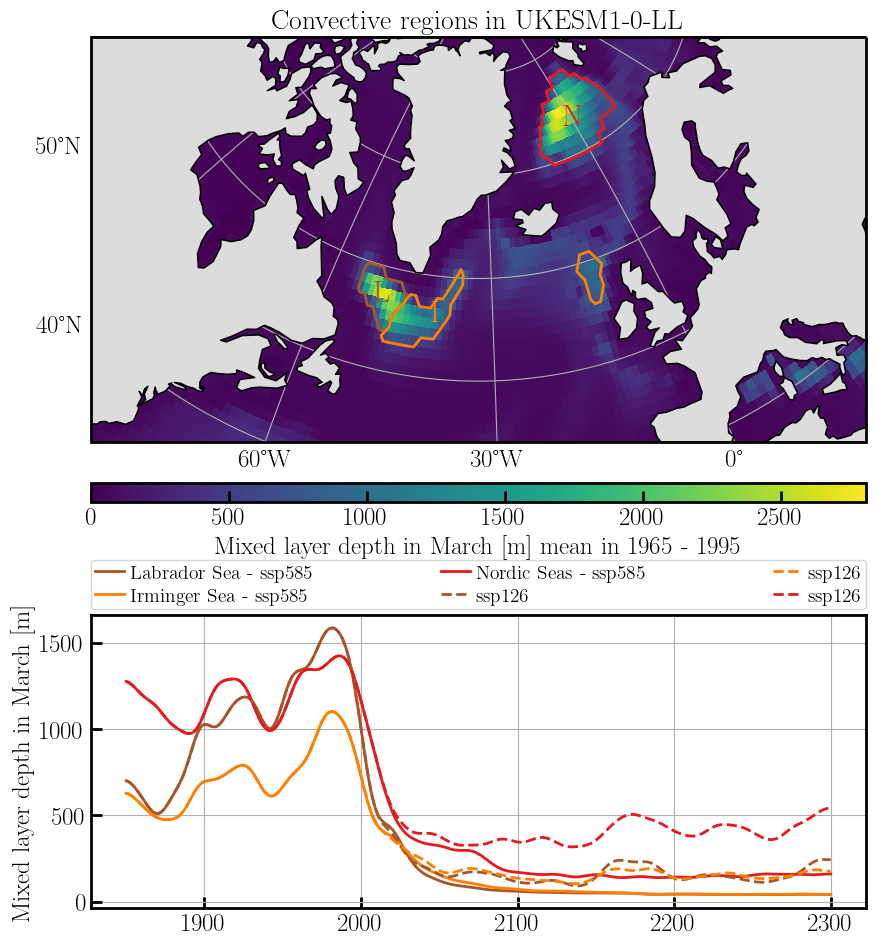

<Figure size 1000x1000 with 0 Axes>

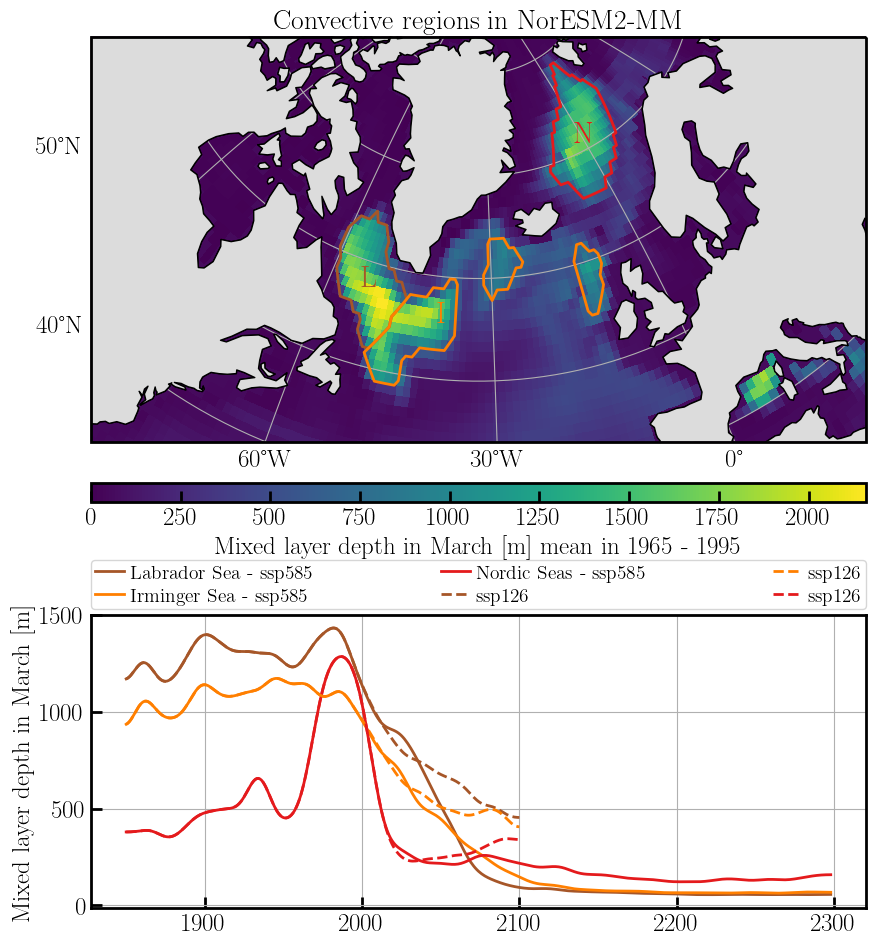

<Figure size 1000x1000 with 0 Axes>

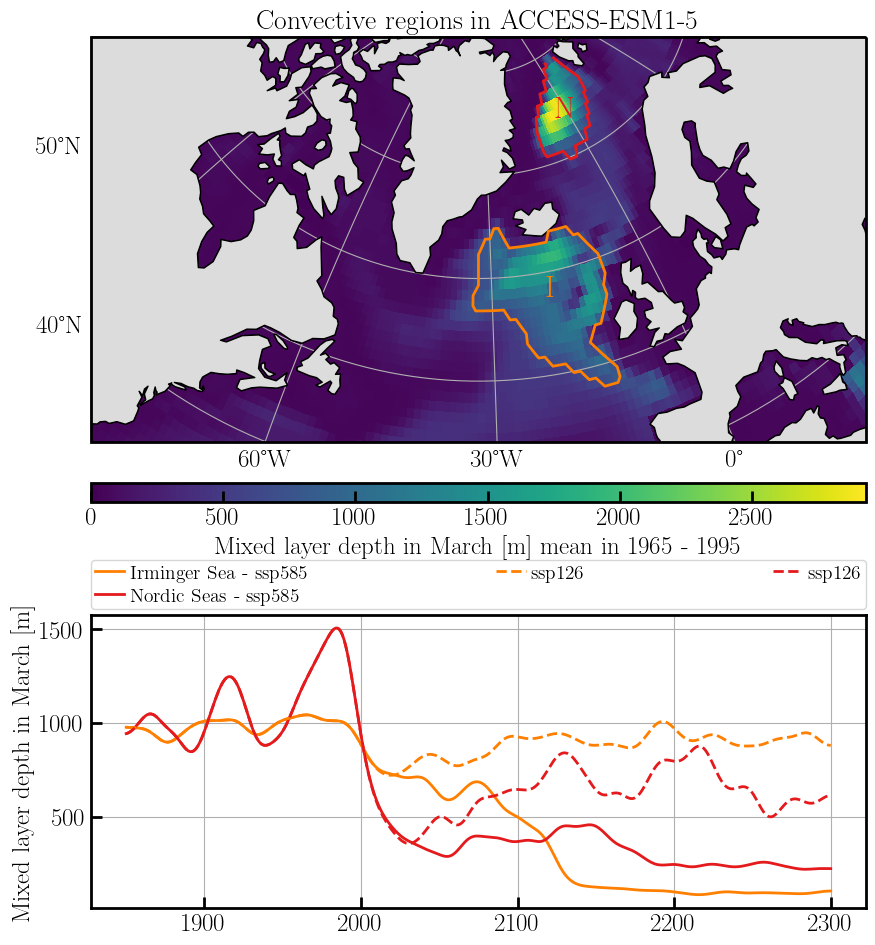

<Figure size 1000x1000 with 0 Axes>

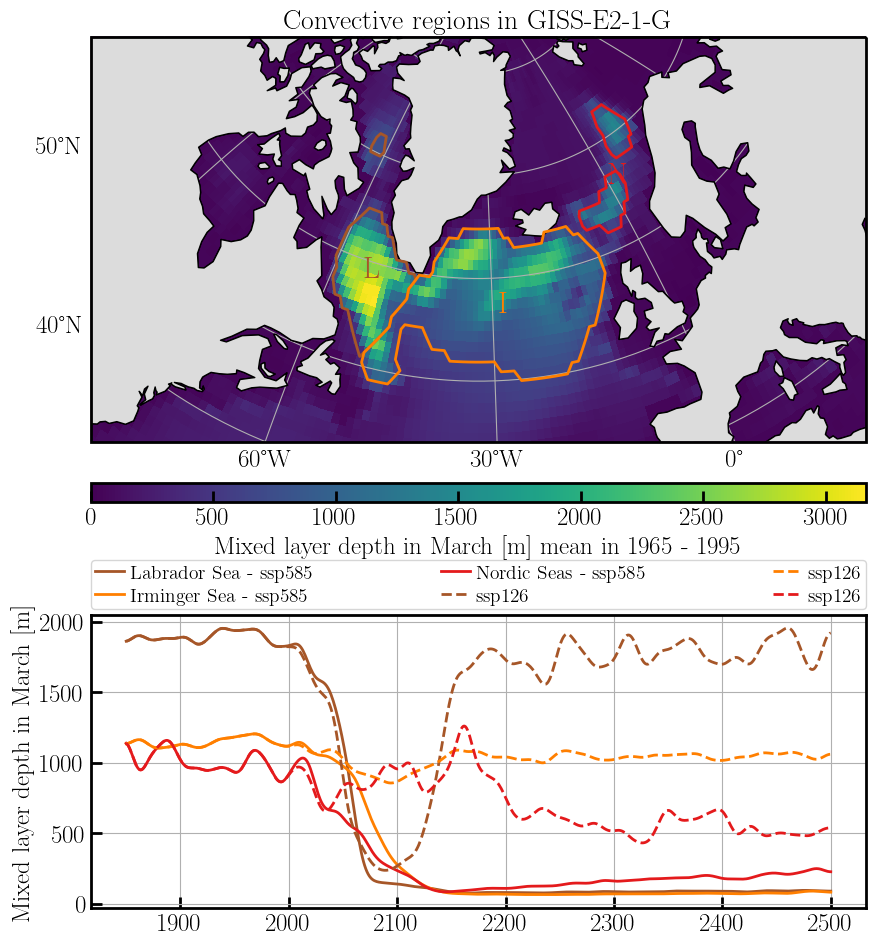

In [21]:
fig_name = 'figure_s3'
new_res_bucket(res_0 = result_bucket['GISS-E2-1-G ssp245 r1i1p1f2'])
plt.gcf().axes[0].set_title(f'Convective regions in GISS-E2-1-G ssp245 r1i1p1f2')
oet.utils.save_fig(name='GISS-E2-1-G_ssp245_r1i1p1f2', sub_dir=fig_name, **save_kw)
new_res_bucket(res_0 = result_bucket['GISS-E2-1-G ssp245 r3i1p1f2'])
plt.gcf().axes[0].set_title(f'Convective regions in GISS-E2-1-G ssp245 r3i1p1f2')
oet.utils.save_fig(name='GISS-E2-1-G_ssp245_r3i1p1f2', sub_dir=fig_name, **save_kw)

for i, g in enumerate(group_labels):
    if i == 4:
        continue
    new_res_bucket(res_0 = result_bucket[g[0]], res_1 = result_bucket[g[1]])
    oet.utils.save_fig(name=g[0].split()[0], sub_dir=fig_name, **save_kw)
    

In [22]:
def plot_extended_water_vars(res_0, res_1=None, axes=None, add_na=False, variables=('sos', 'tos',
                                                                                'hfds', 'siconc')):
    _cc = oet.utils.get_plt_colors()
    del _cc[1:4]
    _cc.append(_cc.pop(2))
#     colors = {res_0.region_names[k]:c for k, c in zip(res_0.labels, _cc)}
    colors = global_color_dict.copy()
    if add_na:
        colors['north_atlantic'] = oet.utils.get_plt_colors()[6]

    ds_list = [
        (oet.read_ds(folder_dict[res_0.label][f'folder_{v}'], max_time=None, add_history=True)
        if folder_dict[res_0.label][f'folder_{v}'] else None)
        for v in variables
        
    ]

#     if res_1 is not None:
    if axes is None:
        _, axes = plt.subplots(len(ds_list),1, figsize=(12,16), sharex=True, gridspec_kw=dict(hspace=0.05))
    
    if add_na:
        reg_labels = ['north_atlantic'] + list(res_0.region_names.values())
        masks=[amoc_deep_dive._base_mask()] + res_0.masks
    else:
        reg_labels = res_0.region_names.values() #res_0.labels
        masks=res_0.masks
    extra_label = '' if res_1 is None else ' ' + res_0.label.split()[1]
    plot_all_on_axes(
        axes=axes,
        ds_list=ds_list,
        reg_labels=reg_labels,
        masks=masks,
        colors=colors,
        extra_label=extra_label,
    )
    if res_1 is not None:
        ds_list = [
            (oet.read_ds(folder_dict[res_1.label][f'folder_{v}'], max_time=None, add_history=True)
            if folder_dict[res_1.label][f'folder_{v}'] else None)
            for v in variables
        ]
        extra_label = res_1.label.split()[1]
        plot_all_on_axes(
            axes=axes,
            ds_list=ds_list,
            reg_labels=reg_labels,
            skip_reg_label=True,
            masks=masks,
            ls='--',
            colors=colors,
            extra_label=extra_label,
        )
        
    plt.suptitle(bake_title(res_0, res_1), y=0.93+(0.02*(res_1 is not None)))
    plt.sca(axes[0])
    axes[0].legend(**oet.utils.legend_kw(ncol=len(reg_labels)))

In [23]:
def add_secax_tos(ax=None, v_0=None, P_rev=1013, S_rev=35):
    ax = ax or plt.gca()
    low = -5
    high = 40
    dummy_t = np.linspace(low, high, int(1e5))
    # Need to have dummy_e_x with large sampling
    
    if v_0 is not None:
        dy = seawater.dens(S=S_rev, T=v_0, P=P_rev)
        dens_due_to_temp = lambda x: seawater.dens(S=S_rev, T=x, P=P_rev) - dy
    else:
        dens_due_to_temp = lambda x: seawater.dens(S=S_rev, T=x, P=P_rev)
    dummy_rho_x = dens_due_to_temp(dummy_t)


    dens_func_inverse = scipy.interpolate.interp1d(dummy_rho_x, dummy_t, bounds_error=False, fill_value='extrapolate')

    secax = ax.secondary_yaxis('right', functions=(dens_due_to_temp, dens_func_inverse))
    if v_0 is not None:
        secax.set_ylabel(f'$\\Delta\\rho_{{eq.}}$ for s={S_rev} [kg/m$^{-3}$]')
    else:
        secax.set_ylabel(f'$\\rho_{{eq.}}$ for s={S_rev} [kg/m$^{-3}$]')
    
def add_secax_sos(ax=None, v_0=None, P_rev=1013, T_rev=5):
    ax = ax or plt.gca()
    low = 20
    high = 60
    dummy_s = np.linspace(low, high, int(1e5))
    # Need to have dummy_e_x with large sampling
    if v_0 is not None:
        dy = seawater.dens(S=v_0, T=T_rev, P=P_rev)
        dens_due_to_sal = lambda x: seawater.dens(S=x, T=T_rev, P=P_rev) - dy
    else:
        dens_due_to_sal = lambda x: seawater.dens(S=x, T=T_rev, P=P_rev)
    dummy_rho_x = dens_due_to_sal(dummy_s)
    
    dens_func_inverse = scipy.interpolate.interp1d(dummy_rho_x, dummy_s, bounds_error=False, fill_value='extrapolate')

    secax = ax.secondary_yaxis('right', functions=(dens_due_to_sal, dens_func_inverse))
    secax.set_ylabel(f'$\\rho_{{eq.}}$ at T={T_rev}$^\circ$C [kg/m$^{-3}$]')
    if v_0 is not None:
        secax.set_ylabel(f'$\\Delta\\rho_{{eq.}}$ at T={T_rev}$^\circ$C [kg/m$^{-3}$]')

In [24]:
def flip_hfds(ds):
    if ds.variable_id != 'hfds':
        return ds
    ds = ds.copy()
    
    for v in list(ds.variables):
        if v.startswith('hfds'):
            ds[v].attrs.update(dict(short_name='Heat loss', units='$\mathrm{W}/\mathrm{m}^2$'))
            ds[v] = -ds[v]
    return ds

In [25]:
def plot_all_on_axes(axes, ds_list, reg_labels, masks, colors, extra_label=None, skip_reg_label=False, **kw,):

    for ax, ds in zip(axes, ds_list):
        if ds is None:
            continue
        amoc_deep_dive.set_time_int(ds)
        update_water_budget_units(ds)
        ds = flip_hfds(ds)
        ax.set_ylabel(oet.plotting.plot.get_ylabel(ds))
        
        v_starts = []
        v_ends = []
        for reg, mask in zip(reg_labels,
                             masks):
            v = smoother(
                        helper_scripts.weighted_mean_array(
                            ds.where(amoc_deep_dive._base_mask(), drop=True).where(mask, drop=False),
                            field=ds.variable_id,
                        ),
            )
            label = ('' if skip_reg_label else str(reg)) + (extra_label if extra_label else '')
            ax.plot(ds['time'].values,
                    v,
                    label=label,
                    c=colors[reg],
                    **kw
                   )
            v_starts.append(v[~np.isnan(v)][0])
            v_ends.append(v[~np.isnan(v)][-1])
        take = min if np.mean(v_ends) > np.mean(v_starts) else max
        # don't add second left axis!
        if ds.variable_id  == 'tos' and not ax.child_axes:
            add_secax_tos(ax, v_0=take(v_starts))
        # don't add second left axis!
        if ds.variable_id  == 'sos' and not ax.child_axes:
            add_secax_sos(ax, v_0=take(v_starts))

In [26]:
def update_water_budget_units(ds, change_to='mm/year', multiplyby=60*60*24*365):
    if ds.variable_id in ['wfo', 'fsitherm', 'pr', 'evs', 'pr-evs', 'friver']:
        ...
    else:
        return ds
    for var in list(ds.variables):
        if var.startswith(ds.variable_id):
            units = ds[var].attrs.get('units')
            if change_to in units:
                continue
            ds[var] = ds[var]*multiplyby
            ds[var].attrs.update(dict(units=change_to))
    return ds

In [27]:
def plot_extended_vars_groups(labels, save_kw, show=True, **kw):
    plot_extended_water_vars(res_0 = result_bucket[labels[0]],res_1 = result_bucket[labels[1]], **kw)
    fig = plt.gcf()
    
    y_lims = [ax.get_ylim() for ax in fig.axes]
    oet.plotting.plot._show(False)
    for i, label in enumerate(labels):
        plot_extended_water_vars(res_0 = result_bucket[label], **kw)
        for ax, yl in zip(plt.gcf().axes, y_lims):
            ax.set_ylim(*yl)
        oet.utils.save_fig(label, **save_kw)
        oet.plotting.plot._show(show)

In [28]:
dict(oet.config.config['variable_label'].items())

{'tas': 'T', 'siconc': 'S.I.C.', 'tos': 'T', 'sos': 'Salinity'}

In [29]:
oet.config.config.read_dict(dict(variable_label=dict(tos='T', 
                                                     sos='Salinity',
                                                     hfds='Heat loss', 
                                                     siconc='Sea-ice cover',
                                                     siconca='Sea-ice cover')))

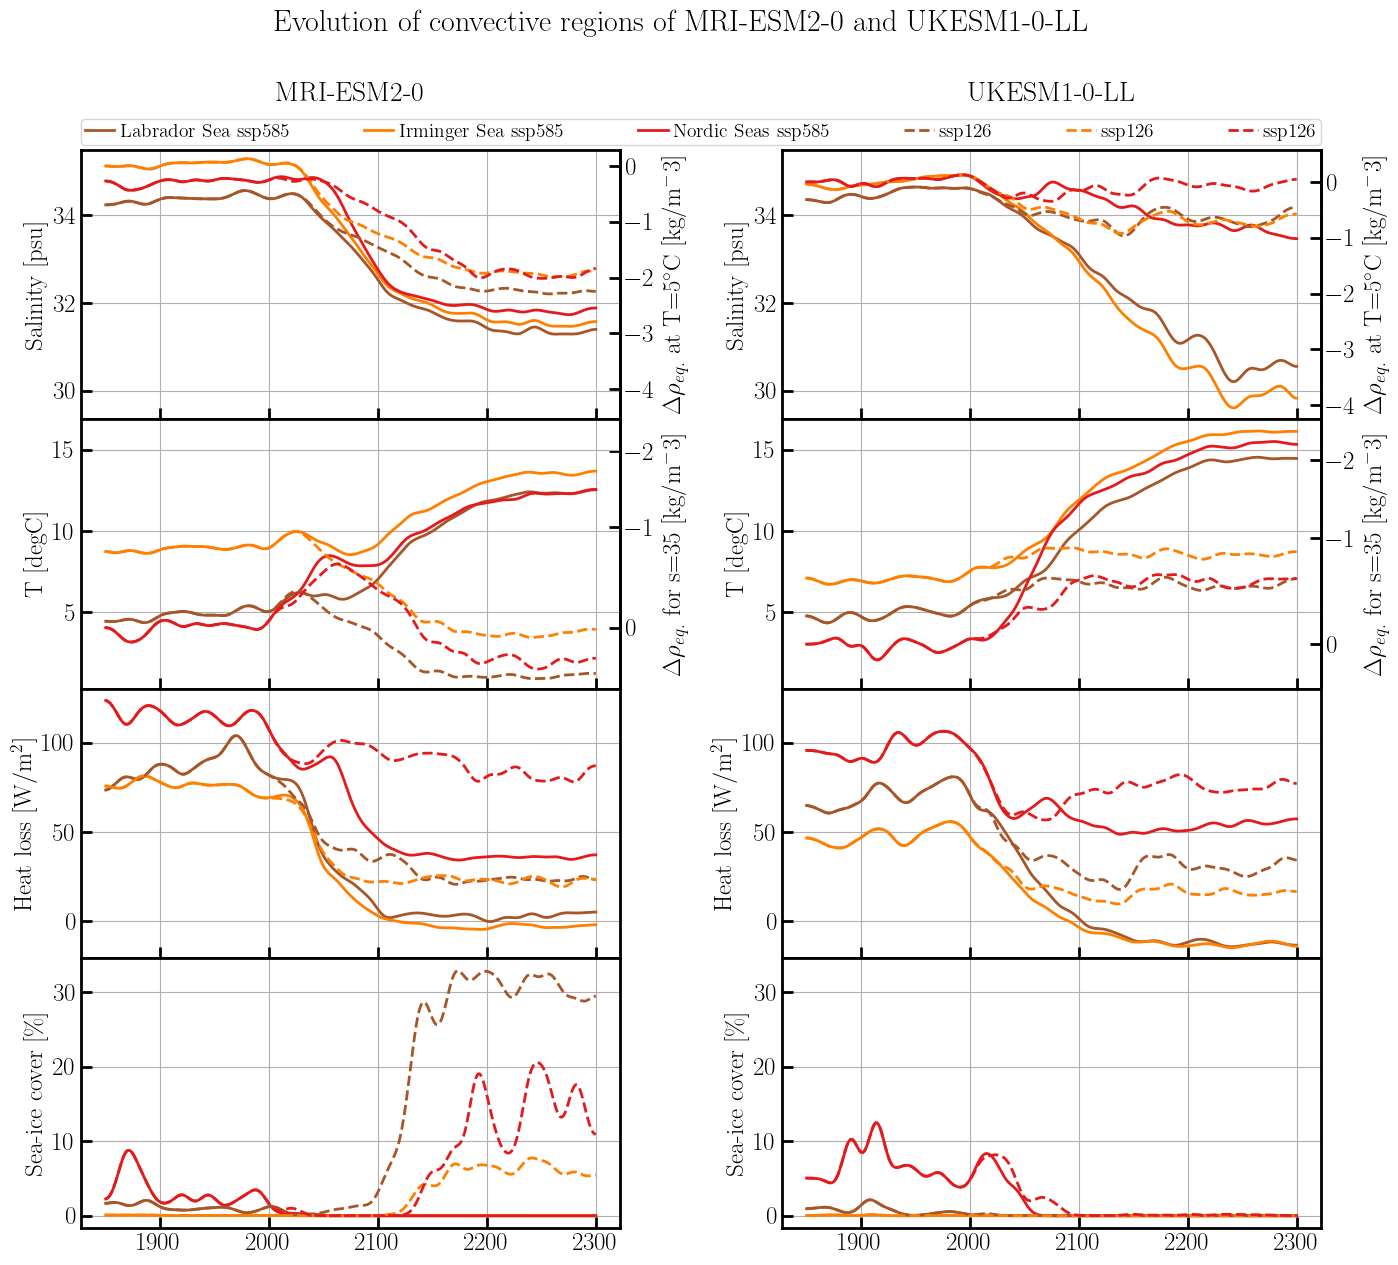

In [30]:
wspace=0.3
_, axes = plt.subplots(4,2, figsize=(16,14), sharex=True, gridspec_kw=dict(hspace=0.0, wspace=wspace))

axes_left = axes[:, 0]
axes_right = axes[:, 1]
g = group_labels[6]
res_0 = result_bucket[g[0]]
res_1 = result_bucket[g[1]]
plot_extended_water_vars(res_0,res_1, axes=axes_left)

title = bake_title(res_0, res_1)
axes_left[0].set_title(title.split()[0], y=1.15)

g = group_labels[7]
res_0 = result_bucket[g[0]]
res_1 = result_bucket[g[1]]
plot_extended_water_vars(res_0,res_1, axes=axes_right)
title = bake_title(res_0, res_1)
axes_right[0].set_title(title.split()[0], y=1.15)


for ax_l, ax_r in zip(axes_left, axes_right):
    y_lims = np.array([ax.get_ylim() for ax in [ax_l, ax_r]])
    
    y_lim = np.min(y_lims), np.max(y_lims)
    
    for ax in ax_l, ax_r:
        ax.set_ylim(*y_lim)
axes_right[0].get_legend().set_visible(False) 
axes_left[0].legend(**oet.utils.legend_kw(
    bbox_to_anchor=(0, 1.02, 2+wspace, 0.32),
    ncol=6, 
    handlelength=1.5,
    labelspacing=0.3, 
    handletextpad=0.3,
    columnspacing=0.8,
    borderpad=0.2,
))
axes[0][0].set_ylabel('Salinity [psu]')
axes[0][1].set_ylabel('Salinity [psu]')
plt.suptitle(f'Evolution of convective regions of {group_labels[6][0].split()[0]} and {group_labels[7][0].split()[0]}',
            y=0.98)
oet.utils.save_fig(f'{group_labels[6][0].split()[0]} and {group_labels[7][0].split()[0]}',
                   **dict(**save_kw, sub_dir='figure_3'))

plt.show()

In [31]:
global_mask_dict = {}
for label, r in result_bucket.items():
    for m_name, m_da in zip(r.labels, r.masks):
        
        global_mask_dict[f'{label}_{m_name}'] = m_da
        global_mask_dict[f'{label}_{r.region_names[m_name]}'] = m_da

In [32]:
from functools import lru_cache

@lru_cache
@oet.utils.timed(seconds=5)
def get_time_series_lev_variable(label, variable,  depth_max:int, mask_id:str,depth_min: int=None,
                                max_lat=None):
    ds = oet.load_glob(amoc_deep_dive_group.read_config(config['read_from'])[label][f'{variable}_path'])
    ds["lev_size"] = xr.DataArray(np.diff(ds["lev_bnds"])[:, 0], dims="lev")
    amoc_deep_dive.set_time_int(ds)
    mask_id = mask_id.split(',')

    masks = [global_mask_dict[f'{label}_{m_id}'] for m_id in mask_id]
    mask = masks[0]
    if len(masks)>1:
        for m in masks[1:]:
            mask = mask | m
    if max_lat:
        mask = mask.copy()        
        mask[mask.lat.values>max_lat] = False
        
    pp = amoc_deep_dive.BaseMaskedProducer(ds=ds.sel(lev=slice(depth_min, depth_max)).copy(),
                                                   mask=mask_to_full_mask(mask))
    return pp.get_mean_time_series(rm=None)


In [33]:
def get_ylim(list_of_arrays:ty.List[np.ndarray], pad=0.05)->ty.Tuple[float,...]:
    _mi, _ma = None, None
    for a in list_of_arrays:
        if _mi is None:
            _mi = np.nanmin(a)
        else:
            _mi = min(_mi, np.nanmin(a))
        if _ma is None:
            _ma = np.nanmax(a)
        else:        
            _ma = max(_ma, np.nanmax(a))
    y_dim = _ma - _mi
    off = y_dim * pad
#     print(off)
    return _mi-off, _ma+off

In [34]:
from dataclasses import dataclass

In [35]:
@dataclass
class WaterBudgetRegion(amoc_deep_dive_group.WaterBudget):
    mask_name: str
    mask_da: xr.DataArray
    ds_dict: ty.Any
    
def plot_north(label, kw_update=None, mask_dict=None, show=False, add_ds_dict=False, **kw):
    mask_dict = mask_dict or {'North Atlantic' : None}
    kw_update = kw_update or config['ts_kw']
    
    ds_dict = {k.split('_')[1]: 
               update_water_budget_units(
                   amoc_deep_dive_group.set_time_int(
                       oet.read_ds(v, add_history=True, max_time=None)
                   )
               ) 
               for k,v in folder_dict[label].items() 
               if 'folder_' in k and v is not None}
    if 'wfo' not in ds_dict or 'siconc' not in ds_dict:
        print(f'{label} incomplete {sorted(ds_dict)}')
        return []
    
    _pr_evs = 'pr-evs'
    if _pr_evs not in ds_dict:
        if 'siconc' in ds_dict:
            ds_dict[_pr_evs] = xr.Dataset(
                {
                    _pr_evs: (1 - ds_dict["siconc"][ds_dict["siconc"].variable_id] / 100)
                    * ds_dict["pr"]["pr"] -ds_dict["evs"]["evs"],
                    "cell_area": ds_dict["siconc"]["cell_area"],
                },
                attrs=dict(variable_id=_pr_evs),
            )
        else:
            ds_dict[_pr_evs] = xr.Dataset(
                {
                    _pr_evs: ds_dict["pr"]["pr"] -ds_dict["evs"]["evs"],
                    "cell_area": ds_dict["evs"]["cell_area"],
                },
                attrs=dict(variable_id=_pr_evs),
            )
    
    residual_name='fsitherm' 
    if residual_name not in ds_dict and all(k in ds_dict for k in 'wfo evs friver siconc'.split()):
        oet.get_logger().error(f'Hacking {residual_name} for {label}')
        ds_dict[residual_name] = xr.Dataset(
                    {
                        residual_name: -(- ds_dict['wfo']['wfo']
                                      - ds_dict['evs']['evs']
                                      + ds_dict['friver']['friver']
                                      + (1 - ds_dict["siconc"][ds_dict["siconc"].variable_id] / 100
                                        )* ds_dict["pr"]["pr"]
                                     ),
                        "cell_area": ds_dict["siconc"]["cell_area"],
                    },
                    attrs=dict(variable_id="residual"),
                )
    
    
    results = []
    variables = kw.pop('variables', [])
    update = kw_update.get(label, {}).copy()
    variables = [v for v in variables if v in ds_dict]
    for mask_name, mask in mask_dict.items():
        
        
        res = amoc_deep_dive_group.ts_budget_inner(ds_dict, mask=mask, **kw, variables=variables)
        results.append(WaterBudgetRegion(**res.__dict__, mask_name=mask_name, mask_da = mask, 
                                         ds_dict=ds_dict if add_ds_dict else None))
        oet.plotting.plot._show(show)
    return results

In [36]:
def plot_water_budget_for_masks(mask_dict, res_0, res_1=None, _label_id=1, extra_suptitle=None,figsize=(14,5), **kw):
    label_dict=dict(fsitherm='sea-ice melt', wfo = 'net water input', friver = 'river runoff' )
    label_dict['pr-evs'] = 'P-E'
    
    kw = kw.copy()
    for k,v in dict(split_ax=False, add_sum_to_label=False,
                    variables =  "wfo friver fsitherm pr-evs".split(),minus_variables = (None,),).items():
        kw.setdefault(k, v)
    
    
    results_0 = plot_north(res_0.label, mask_dict=mask_dict, **kw)
    
    if not len(results_0):
        plt.suptitle((extra_suptitle if extra_suptitle is not None else '') + res_1.label.split()[0], y=1.2)
        return
    if res_1 is not None:
        results_1 = plot_north(res_1.label, mask_dict=mask_dict, **kw)
    else:
        result_1 = []
    _, axes = plt.subplots(1,len(results_0), figsize=figsize, sharey=True, gridspec_kw=dict(wspace=0))
    plt.suptitle((extra_suptitle if extra_suptitle is not None else '') + res_1.label.split()[0], y=1.2)
    if len(results_0) == 1:
        axes = [axes]
    cc = oet.utils.get_plt_colors()
    c_dict = dict(zip(results_0[0].labels, cc))
#     print(c_dict)
    for ax, res in zip(axes, results_0):
        plt.sca(ax)

        for x,y,l in zip(res.timestamps, res.y_vals, res.labels):
            yy = smoother(y)
            off = np.mean(yy[res.reference_slice])
            plt.plot(x,yy-off,label=f'{label_dict[l]} - {res_0.label.split()[_label_id]}', c=c_dict[l])

        plt.title(f'{res.mask_name}',y=1.0)
    
    for ax, res in zip(axes, results_1):
        plt.sca(ax)

        for x,y,l in zip(res.timestamps,res.y_vals, res.labels):
            yy = smoother(y)
            off = np.mean(yy[res.reference_slice])
            plt.plot(x,yy-off,c=c_dict[l], ls='--', label=f'{res_1.label.split()[_label_id]}',)
        plt.axvspan(*res.reference_period, label='reference period', color='k', alpha=0.1)
    y_label =  f"$\\Delta$Water flux [mm/year]"  #res.label_dy
    axes[0].set_ylabel(y_label)
    if len(axes)> 1:
        axes[-1].set_ylabel(y_label)
        axes[-1].yaxis.tick_right()
        axes[-1].yaxis.set_label_position("right")

    # axes[-1].yaxis.set_ticklabels(axes[0].yaxis.get_ticklabels())

    axes[0].legend(**oet.utils.legend_kw(**{'ncol':4,
        'bbox_to_anchor': (0.0, 1.12, len(axes), 0.32)
    }))

   
    return results_0, results_1

In [37]:
da_na_45n = amoc_deep_dive._base_mask(lat_min=45, lat_max=80, lon_min=-75, lon_max=25)

In [38]:
mask = dict()
masks = regionmask.defined_regions.natural_earth_v5_0_0.ocean_basins_50.mask(res_0.full_ds)
for i, name in (zip(masks.attrs['flag_values'], masks.attrs['flag_meanings'].split())):
    name = name.replace('_', ' ')
    if name in rename_dict.values():
        cache_name = name
    else:
        cache_name = rename_dict.get(name, 'skip')
    if cache_name != 'skip':
        print(cache_name, name)
        if cache_name in mask:
            mask[cache_name] = (masks == i ) | mask[cache_name]
        else:
            mask[cache_name] = (masks == i )

Irminger Sea North Atlantic Ocean
Labrador Sea Labrador Sea
Labrador Sea Baffin Bay
Nordic Seas Norwegian Sea
Nordic Seas Greenland Sea
Labrador Sea Davis Strait


In [39]:
tot_mask = mask['Nordic Seas'].astype(int)*1 + mask['Irminger Sea'].astype(int)*2 + mask['Labrador Sea'].astype(int)*3

In [40]:
index_errors={1: 'wfo is missing', 
              3: 'budget does not close',
              4: 'budget does not close',
              8: 'not checked',
              len(group_labels)-1: 'budget does not close'
             }

In [41]:
config['ts_kw']['GISS-E2-1-G ssp126 r4i1p1f2']['minus_variables'] = [None,]
config['ts_kw']['GISS-E2-1-G ssp585 r4i1p1f2']['minus_variables'] = [None,]
config['ts_kw'][group_labels[4][0]]['minus_variables'] = [None,]
config['ts_kw'][group_labels[4][1]]['minus_variables'] = [None,]

# config['ts_kw'][group_labels[len(group_labels)-1][0]]['minus_variables'] = [None,]
# config['ts_kw'][group_labels[len(group_labels)-1][1]]['minus_variables'] = [None,]

In [42]:
list(enumerate(group_labels))

[(0, ['ACCESS-CM2 ssp585 r1i1p1f1', 'ACCESS-CM2 ssp126 r1i1p1f1']),
 (1, ['CESM2-WACCM ssp585 r1i1p1f1', 'CESM2-WACCM ssp126 r1i1p1f1']),
 (2, ['CanESM5 ssp585 r1i1p1f1', 'CanESM5 ssp126 r1i1p1f1']),
 (3, ['GISS-E2-1-G ssp585 r1i1p1f2', 'GISS-E2-1-G ssp126 r1i1p1f2']),
 (4, ['GISS-E2-1-G ssp245 r3i1p1f2', 'GISS-E2-1-G ssp245 r1i1p1f2']),
 (5, ['IPSL-CM6A-LR ssp585 r1i1p1f1', 'IPSL-CM6A-LR ssp126 r1i1p1f1']),
 (6, ['MRI-ESM2-0 ssp585 r1i1p1f1', 'MRI-ESM2-0 ssp126 r1i1p1f1']),
 (7, ['UKESM1-0-LL ssp585 r4i1p1f2', 'UKESM1-0-LL ssp126 r4i1p1f2']),
 (8, ['NorESM2-MM ssp585 r1i1p1f1', 'NorESM2-MM ssp126 r1i1p1f1']),
 (9, ['ACCESS-ESM1-5 ssp585 r1i1p1f1', 'ACCESS-ESM1-5 ssp126 r1i1p1f1']),
 (10, ['GISS-E2-1-G ssp585 r1i1p1f2', 'GISS-E2-1-G ssp126 r1i1p1f2'])]

In [43]:
config['ts_kw'][group_labels[9][0]] = config['ts_kw'][group_labels[0][0]]
config['ts_kw'][group_labels[9][1]] = config['ts_kw'][group_labels[0][1]]

In [44]:
# @lru_cache
def read_fwt_for_source_and_ssp(source_id, ssp):
    p_ssp = glob.glob(f'/data/volume_2/manual_download/mtot_*{source_id}*{ssp}*.nc')
    assert len(p_ssp) == 1, p_ssp
    p_ssp=p_ssp[0]
    return oet.load_glob(p_ssp)


In [45]:
def fw_convergence(ds, field='mtot', lat_min = 45, lat_max = 80):
    
    fw_n = ds[field].sel(lat=lat_max, method='nearest')
    fw_s = ds[field].sel(lat=lat_min, method='nearest')
    return fw_s - fw_n

def sv_to_mm_per_year(da, area=None):
    if area is None:
        raise ValueError('No area!')
#         area = 12222064049446.7
    sv_to_m3 = 1e6
    m3_to_mm = 1e3/area
    
    per_s_to_year = 365*24*3600
    
    sv = da
    return sv * sv_to_m3 * m3_to_mm * per_s_to_year

In [46]:
rename_dict = {'Greenland Sea': 'Nordic Seas', 
               'Norwegian Sea': 'Nordic Seas',
               'North Atlantic Ocean': 'Irminger Sea',
               'Baffin Bay': 'Labrador Sea',
               'Davis Strait': 'Labrador Sea'}

In [47]:
da_na_45n = amoc_deep_dive._base_mask(lat_min=45, lat_max=80, lon_min=-75, lon_max=25)
da_na_45n_65n = da_na_45n.copy()
da_na_45n_65n[da_na_45n_65n.lat>65] = False

da_na_65n_80n = da_na_45n.copy()
da_na_65n_80n[da_na_65n_80n.lat<65] = False

In [56]:
def add_mask_to_figure(mask = da_na_45n,
                       n_x=1, n_y=1, idx=1, fig=None,
                      projection='NearsidePerspective',
                       ctp_kw=None,
                       subplot_kw = None
                      ):
    

    import cartopy.crs as ccrs
    import cartopy.feature as cfeature

    fig = fig or plt.gcf()
    subplot_kw = subplot_kw or dict(position=[0.13, 0.57, 0.30, 0.3])
    
    ctp_kw = ctp_kw or dict(projection=projection, central_longitude=-25,central_latitude=60,satellite_height=0.5e7)
    ax = fig.add_subplot(1,1,1,
                         projection=oet.plotting.plot.get_cartopy_projection(**ctp_kw),
                         **subplot_kw
                        )
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '110m', edgecolor='k', facecolor='gainsboro', zorder=2))
    ax.add_feature(cfeature.COASTLINE)
    gl = ax.gridlines(draw_labels=False, zorder=1)
    gl.top_labels=False
    gl.right_labels=False
    gl.left_labels=False
    gl.bottom_labels=False
    da = (mask.where(amoc_deep_dive._base_mask(), drop=False).copy()>0).astype(np.float16)
    da.plot(ax=ax,transform=oet.plotting.plot.get_cartopy_transform(), add_colorbar=False, cmap='Blues')
    return gl

In [57]:
@dataclass
class RegSel:
    lat_min: float
    lat_max: float
    lon_min: float
    lon_max: float
        
    label: str
        
    def modify_mask(self, mask):
        a = mask.lat < self.lat_min
        a = a | (mask.lat > self.lat_max)
        a = a | ((mask.lon-360 < self.lon_min) & (mask.lon > self.lon_max))

        m2 = mask.copy()
        m2.data[a.values] = False
        return m2
    
    def __str__(self):
        return f'{self.label}_{self.lat_min}-{self.lat_max}N'

In [58]:
r_up = RegSel(lat_max=75, lat_min=60, lon_min=-45, lon_max=15, label='Nordic Seas')
r_down = RegSel(lat_max=60, lat_min=45, lon_min=-1e6, lon_max=1e6, label='Subpolar latitudes')

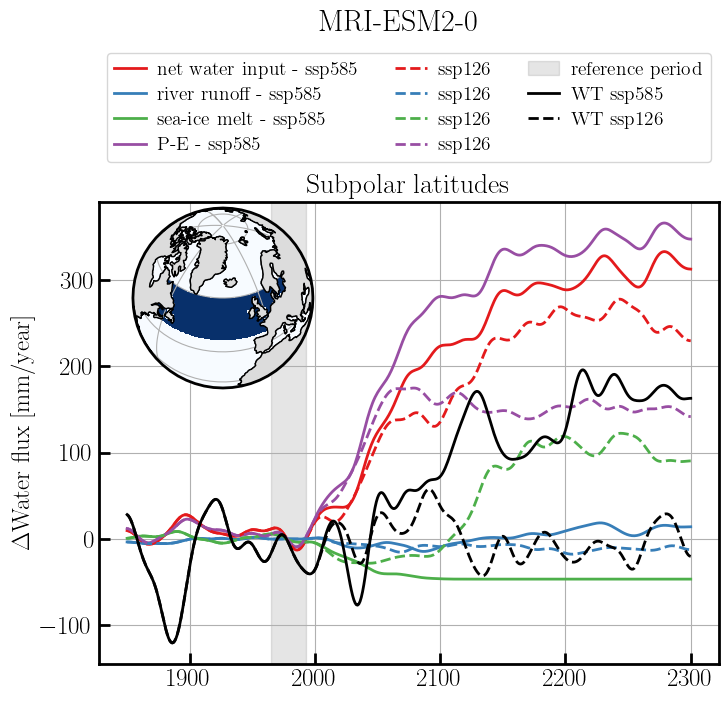

In [59]:
i = 6
ds_585 = read_fwt_for_source_and_ssp('MRI-ESM2-0', 'ssp585')
ds_126 = read_fwt_for_source_and_ssp('MRI-ESM2-0', 'ssp126')
g = group_labels[i]
kw = dict(rm=30, average_slice=slice(115,144), 
          update_labels=False,
          add_ds_dict=True,
          figsize=(8,6),
          minus_variables=config['ts_kw'].get(g[0], {}).get('minus_variables', [None]))

if 'ssp245' in g[0]:
    kw.update(dict(_label_id=2))
if i in index_errors:
    kw.update(dict(extra_suptitle=index_errors[i].upper() + '! '))

res_0 = result_bucket[g[0]]
res_1 = result_bucket[g[1]]

for reg in [r_down]:
    mask = reg.modify_mask(da_na_45n)

    label = reg.label
    wb_res = plot_water_budget_for_masks(
            mask_dict = {label: mask},
            res_1=res_1,
            res_0=res_0,
            **kw,
    );
    da_585 = sv_to_mm_per_year(fw_convergence(ds_585, lat_min=reg.lat_min, lat_max=reg.lat_max),
                               area=res_0.full_ds['cell_area'].where(mask).sum())
    ref_585 = da_585.values[slice(115, 144, None)].mean()
    da_126 = sv_to_mm_per_year(fw_convergence(ds_126, lat_min=reg.lat_min, lat_max=reg.lat_max),
                               area=res_0.full_ds['cell_area'].where(mask).sum())
    ref_126 = da_126.values[slice(115, 144, None)].mean()

    plt.plot(da_585.time, smoother(da_585)-ref_585, c='black', label='WT ssp585')
    plt.plot(da_126.time, smoother(da_126)-ref_126, c='black', label='WT ssp126', ls='--')
    plt.legend(**oet.utils.legend_kw(**{'ncol':3,'bbox_to_anchor': (0.0, 1.07, 1, 0.32),
                                        'labelspacing': 0.4,
                                        'handletextpad': 0.6,
                                         'borderaxespad':0.4,
                                        'handlelength': 1.6
                                       }))
    add_mask_to_figure(mask, #subplot_kw=dict(position=[0.13, 0.2, 0.30, 0.3])
                      )
    
    
    oet.utils.save_fig(f'water_budget_{res_0.label}_{reg}', **save_kw, sub_dir = 'figure_s4')
    plt.show()

09-30 16:37:58 | oet          | ERROR    | Hacking fsitherm for UKESM1-0-LL ssp585 r4i1p1f2 | plot_north (l. 45)
09-30 16:38:03 | oet          | ERROR    | Hacking fsitherm for UKESM1-0-LL ssp126 r4i1p1f2 | plot_north (l. 45)


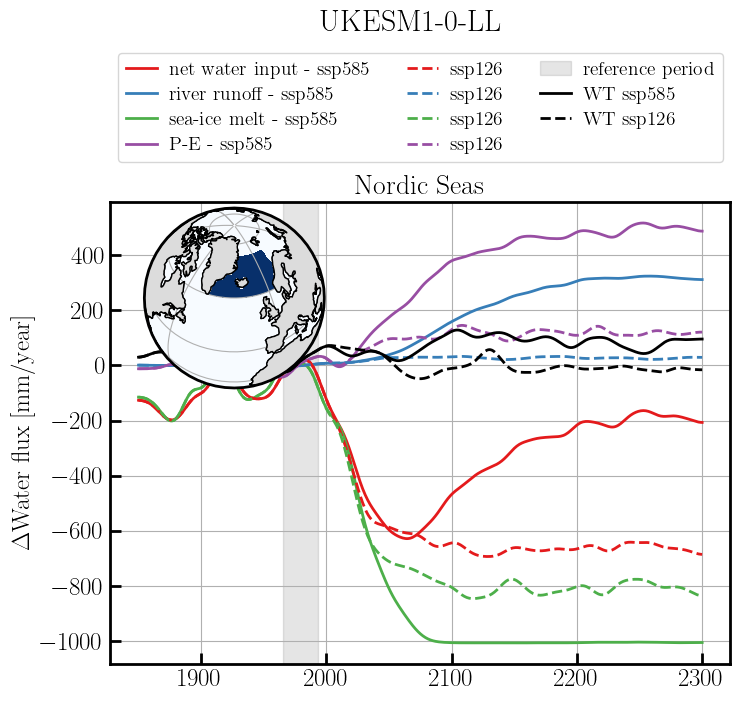

09-30 16:38:09 | oet          | ERROR    | Hacking fsitherm for UKESM1-0-LL ssp585 r4i1p1f2 | plot_north (l. 45)
09-30 16:38:15 | oet          | ERROR    | Hacking fsitherm for UKESM1-0-LL ssp126 r4i1p1f2 | plot_north (l. 45)


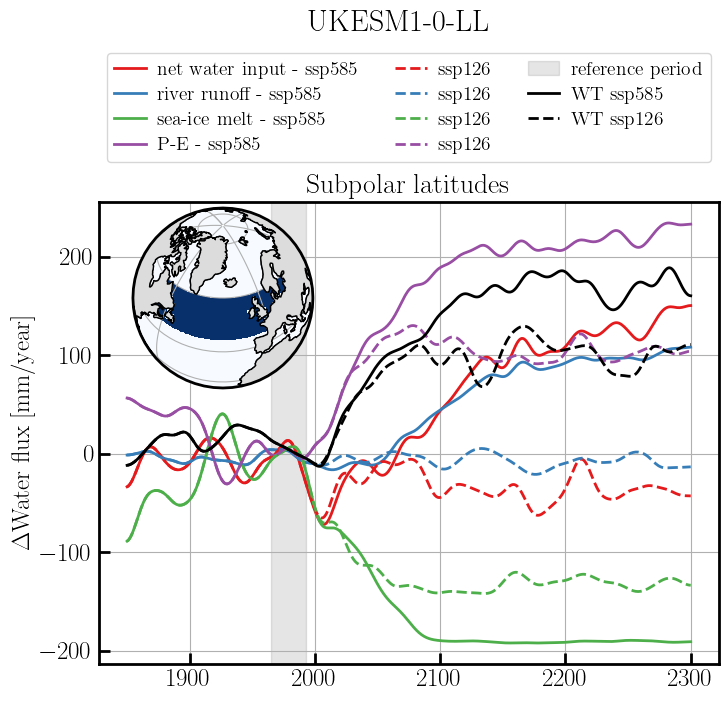

In [60]:
i = 7
g = group_labels[i]
ds_585 = read_fwt_for_source_and_ssp('UKESM1-0-L', 'ssp585')
ds_126 = read_fwt_for_source_and_ssp('UKESM1-0-L', 'ssp126')
kw = dict(rm=30, 
#           average_slice=slice(115,144), 
           average_slice=slice(115,144), 
          update_labels=False,
          figsize=(8,6),
          add_ds_dict=True,
          minus_variables=config['ts_kw'].get(g[0], {}).get('minus_variables', [None]))

if 'ssp245' in g[0]:
    kw.update(dict(_label_id=2))
if i in index_errors:
    kw.update(dict(extra_suptitle=index_errors[i].upper() + '! '))

res_0 = result_bucket[g[0]]
res_1 = result_bucket[g[1]]
for reg in [r_up, r_down]:
# for reg in regions:
    mask = reg.modify_mask(da_na_45n)

    label = reg.label
    wb_res = plot_water_budget_for_masks(
            mask_dict = {label: mask},
            res_1=res_1,
            res_0=res_0,
            **kw,
    );
    da_585 = sv_to_mm_per_year(fw_convergence(ds_585, lat_min=reg.lat_min, lat_max=reg.lat_max),
                               area=res_0.full_ds['cell_area'].where(mask).sum())
    ref_585 = da_585.values[kw['average_slice']].mean()
    da_126 = sv_to_mm_per_year(fw_convergence(ds_126, lat_min=reg.lat_min, lat_max=reg.lat_max),
                               area=res_0.full_ds['cell_area'].where(mask).sum())
    ref_126 = da_126.values[kw['average_slice']].mean()

    plt.plot(da_585.time, smoother(da_585)-ref_585, c='black', label='WT ssp585')
    plt.plot(da_126.time, smoother(da_126)-ref_126, c='black', label='WT ssp126', ls='--')
    plt.legend(**oet.utils.legend_kw(**{'ncol':3,'bbox_to_anchor': (0.0, 1.07, 1, 0.32),
                                        'labelspacing': 0.4,
                                        'handletextpad': 0.6,
                                         'borderaxespad':0.4,
                                        'handlelength': 1.6
                                       }))
    add_mask_to_figure(mask, subplot_kw=dict(position=[0.13, 0.2, 0.30, 0.3]) if r.label == 'Nordic Seas' else None
                      )
    
    
    plt.show()